In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 1: Data Exploration

In [45]:
df = pd.read_csv("./electricity-consumption-processed.csv")


### First rows and useful statistics

Displaying the first rows of the dataset.

In [46]:
df.head(10)

,datetime,substation,feeder,consumption
0,2017-01-01T00:00:00,A,A1,64.671363
1,2017-01-01T01:00:00,A,A1,58.000000
2,2017-01-01T02:00:00,A,A1,58.000000
3,2017-01-01T03:00:00,A,A1,58.000000
4,2017-01-01T04:00:00,A,A1,52.000000
5,2017-01-01T05:00:00,A,A1,45.000000
6,2017-01-01T06:00:00,A,A1,42.000000
7,2017-01-01T07:00:00,A,A1,43.000000
8,2017-01-01T08:00:00,A,A1,45.000000
9,2017-01-01T09:00:00,A,A1,44.000000


Displaying the shape of the dataset on form (rows, column)

In [47]:
df.shape

(1928520, 4)

From this we can see that they have split the time-series in intervals of 1 hour, and a total of 24 points of data per day. Furthermore, the dataset also points to a substation. All the data from substation A is the following:

In [48]:
substation_df = df[df['substation'] == 'A']
substation_df.shape

(70128, 4)

With 70 128 rows of data for one subregion we have the following dates, weeks and years spanning in the dataset:

In [49]:
points_per_day = 24
dataset_in_days = substation_df.shape[0] / points_per_day

print(f"Days in dataset: {dataset_in_days}")

dataset_in_weeks = dataset_in_days / 7 # 7 days per week

print(f"Weeks in dataset: {dataset_in_weeks}")

dataset_in_years = dataset_in_weeks / 52 # 52 weeks in a year

print(f"Years in dataset: {dataset_in_years}")


Days in dataset: 2922.0
Weeks in dataset: 417.42857142857144
Years in dataset: 8.027472527472527


Creating statistics of the dataset

In [50]:
df.describe()

,consumption
count,1.884960e+06
mean,1.018534e+02
std,6.220330e+01
min,1.264627e+00
25%,5.300000e+01
50%,8.825000e+01
75%,1.410000e+02
max,4.120000e+02


**Identifyting missing values**

In [51]:
missing_values = df.isnull().sum()
print(missing_values)

datetime           0
substation         0
feeder             0
consumption    43560
dtype: int64


**Identifying unique values**

In [52]:
unique_consumption = df['consumption'].unique()
unique_consumption.size

113864

There are 113 864 unique values for the consumption columm.

**Outliers**

Have chosen to use Interquartile Range (IQR) as this is more suitable to handle skewed data. This is certainly the case here, as electricity consumption varies from day to day, as well as the season and weather conditions. If the data had been normally ditributed, calculating ouliers using z-score would be more useful.

In [53]:
q1 = df['consumption'].quantile(0.25)
q3 = df['consumption'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['consumption'] < lower_bound) | (df['consumption'] > upper_bound)]
print(outliers)

                    datetime substation feeder  consumption
71104    2017-02-10T16:00:00          B     B1        285.0
71392    2017-02-22T16:00:00          B     B1        288.0
71600    2017-03-03T08:00:00          B     B1        288.0
71601    2017-03-03T09:00:00          B     B1        281.0
71603    2017-03-03T11:00:00          B     B1        307.0
...                      ...        ...    ...          ...
1892579  2020-11-25T11:00:00          N     N3        276.0
1892582  2020-11-25T14:00:00          N     N3        306.0
1892583  2020-11-25T15:00:00          N     N3        288.0
1892966  2020-12-11T14:00:00          N     N3        277.0
1892967  2020-12-11T15:00:00          N     N3        277.0

[17444 rows x 4 columns]


Of the total of 1 928 520 total entries, there are 17 444 outliers.

In [54]:
round(outliers.size / df.size * 100, 4)

0.9045

This accounts for approximately 0.9045 %

# Task 2: Data Cleaning

Displaying where the missing values are located in the dataset.

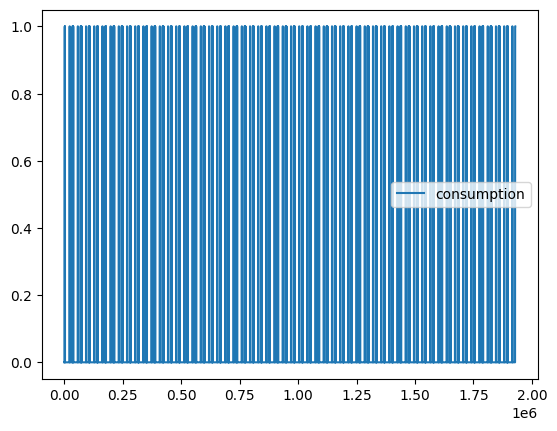

In [55]:
fig, ax = plt.subplots()

consumption_null = df['consumption'].isnull()
ax.plot(consumption_null)

ax.legend(['consumption'])


We chose to linear interpolate between the last known value and the next known. This is mainly because missing datapoints seems to be random. It seems logical to interpolate the data as it maps back to the real world, where seasonal changes vary, but dates within a short timeperiod should corralate more or less.

In [56]:
df['consumption'] = df['consumption'].interpolate(method='linear')
df['consumption']


0          64.671363
1          58.000000
2          58.000000
3          58.000000
4          52.000000
             ...    
1928515    35.000000
1928516    35.000000
1928517    35.000000
1928518    35.000000
1928519    35.000000
Name: consumption, Length: 1928520, dtype: float64

# Task 3: Handling outliers

Display IQR (Interquartile range), outliers shown by the red circles.

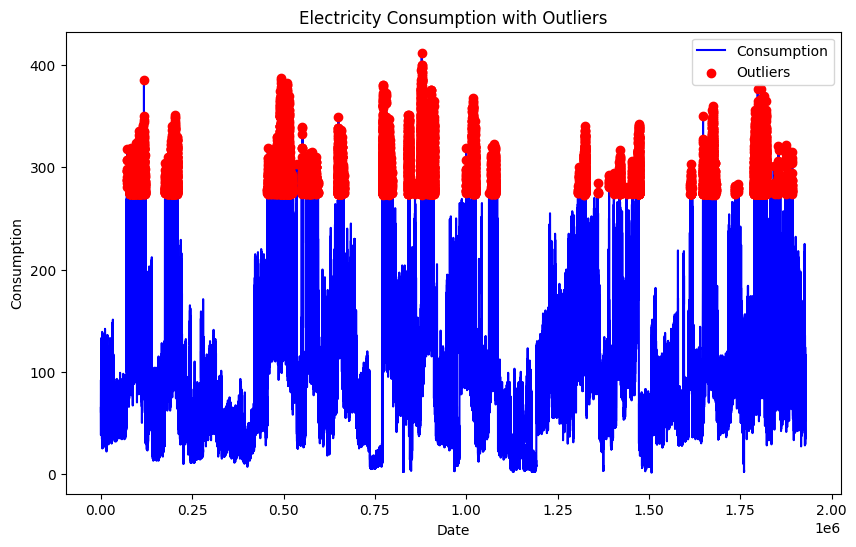

In [57]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['consumption'], label='Consumption', color='blue')

plt.scatter(outliers.index, outliers['consumption'], color='red', label='Outliers', zorder=5)

plt.title('Electricity Consumption with Outliers')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()

plt.show()

We chose to cap the data, due to the fact that the amount i rather large (a bit less than 70 000) and skewed. This will help reduce the impact of extreme values, but not remove them completely. Furthermore, our interest in this dataset is to make predictions and spot general trends. In this case outliers are note perticularly interesting, and we therefore find it natural to minimise their effect without completely removing them. To cap the dataset rather than transforming it also makes it easier to explain the data to a potential client.

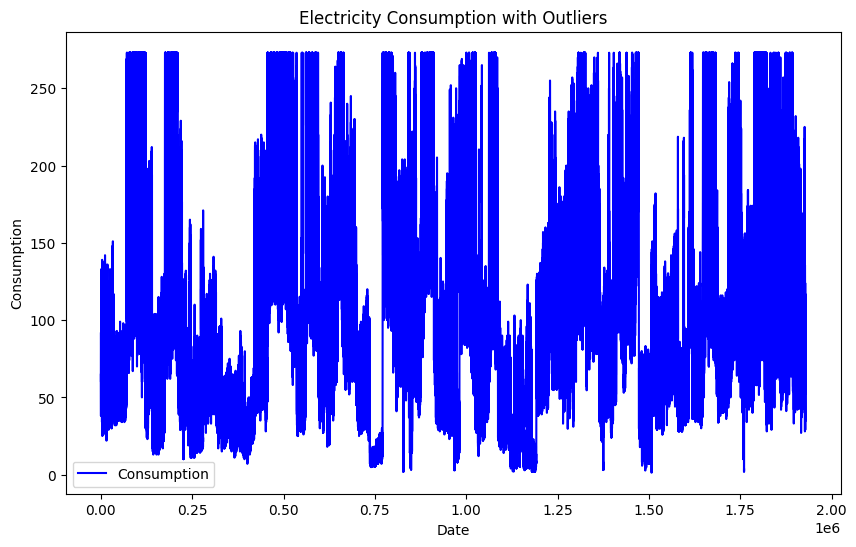

In [60]:
df['consumption'] = df['consumption'].clip(lower=lower_bound, upper=upper_bound)

plt.figure(figsize=(10, 6))

plt.plot(df.index, df['consumption'], label='Consumption', color='blue')

plt.title('Electricity Consumption when capped')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()

plt.show()